## Используемые библиотеки

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from bokeh.plotting import figure, show
from bokeh.charts import TimeSeries, show, output_file, TimeSeries
from collections import OrderedDict
from bokeh.io import output_notebook

output_notebook()

%matplotlib inline


Loading BokehJS ...

## Чтение данных

In [168]:
data = pd.read_csv('training.csv', parse_dates=['Date'], index_col='Date')
ts = pd.Series(np.asarray(data['Value'], dtype=np.float))
bokeh_plot = TimeSeries(data, width=900, height=500, color='blue',
                        ylabel='Значения', xlabel='Время', legend=False)
show(bokeh_plot)


## Проверка на стационарность

### Скользящее среднее и стандартное отклонение

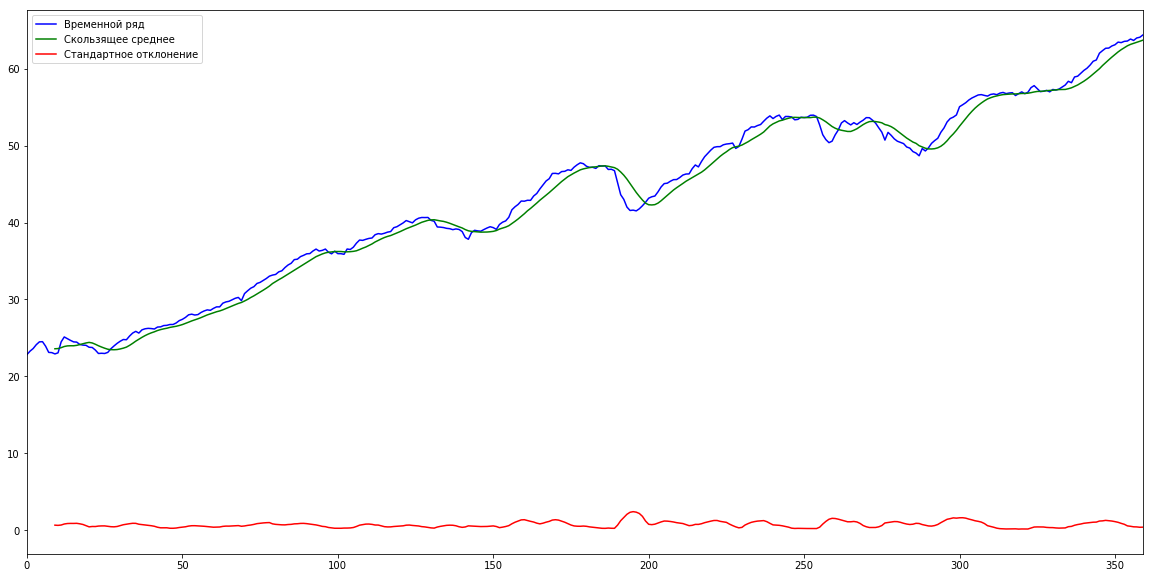

In [169]:
ts.plot(color='b', legend=True, figsize=(20, 10), label='Временной ряд')
ts.rolling(window=10).mean().plot(color='g', legend=True,
                                  label='Скользящее среднее')
ts.rolling(window=10).std().plot(color='r', legend=True,
                                 label='Стандартное отклонение')


### Вывод
* Из графика следует, что во временном ряде есть тренд, т.е. ряд не стационарен

### Тест Дики-Фуллера

In [170]:
def dfTest(ts, isPrint=True):
    test = sm.tsa.adfuller(ts)
    if isPrint:
        print ('p-value: ', test[0])
        print ('Critical values: ', test[4])
    if test[0] > test[4]['5%']:
        if isPrint:
            print ('Единичный корень есть, временной ряд не стационарен')
        return False
    else:
        if isPrint:
            print ('Единичных корней нет, временной ряд стационарен')
        return True
    return False

dfTest(ts)


p-value:  -0.253391179928
Critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459002}
Единичный корень есть, временной ряд не стационарен


False

## Разложение временного ряда на тренд, сезональность остаток в соответствии с аддитивной и мультипликативной моделями

In [171]:
def showPlot(x, title=''):
    plt.figure(figsize=(7, 2))
    plt.plot(x)
    plt.title(title)
    plt.show()


def models(data, model_s, title):
    decomp = seasonal_decompose(data.Value, model=model_s)
    decomp.trend.plot(color='g', legend=True, label='Тренд',
                      title=title, figsize=(10, 4))
    decomp.seasonal.plot(color='r', legend=True, label='Сезональность')
    decomp.resid.plot(color='b', legend=True, label='Остаток')
    plt.show()

    showPlot(decomp.trend, 'Тренд')
    print('Проверка тренда на стационарность\n')
    ts_t = decomp.trend
    ts_t.dropna(inplace=True)
    dfTest(ts_t)

    showPlot(decomp.resid, 'Остаток')
    print('\nПроверка сезональности на стационарность\n')
    ts_t = decomp.seasonal
    ts_t.dropna(inplace=True)
    dfTest(ts_t)

    showPlot(decomp.seasonal, 'Сезональность')
    print('\nПроверка остатка на стационарность\n')
    ts_t = decomp.resid
    ts_t.dropna(inplace=True)
    dfTest(ts_t)


data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)


### Аддитивная модель

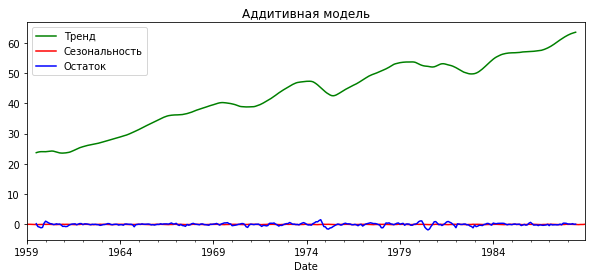

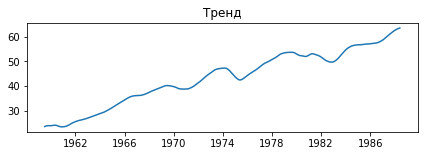

Проверка тренда на стационарность

p-value:  -0.861576033358
Critical values:  {'1%': -3.4503224123605194, '5%': -2.8703384787266608, '10%': -2.5714576124885218}
Единичный корень есть, временной ряд не стационарен


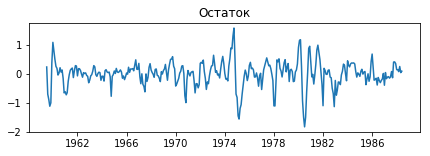


Проверка сезональности на стационарность

p-value:  -1.45267497959e+14
Critical values:  {'1%': -3.4492815848836296, '5%': -2.8698813715275406, '10%': -2.5712138845950587}
Единичных корней нет, временной ряд стационарен


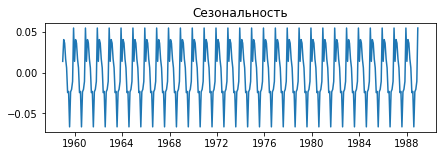


Проверка остатка на стационарность

p-value:  -7.48556383377
Critical values:  {'1%': -3.4496162602188187, '5%': -2.870028369720798, '10%': -2.5712922615505627}
Единичных корней нет, временной ряд стационарен


In [172]:
models(data, 'additive', 'Аддитивная модель')


### Мультипликативная модель

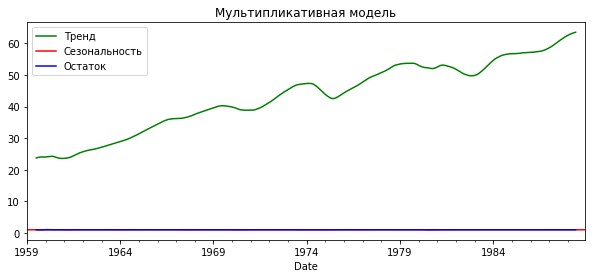

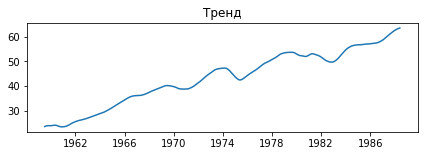

Проверка тренда на стационарность

p-value:  -0.861576033358
Critical values:  {'1%': -3.4503224123605194, '5%': -2.8703384787266608, '10%': -2.5714576124885218}
Единичный корень есть, временной ряд не стационарен


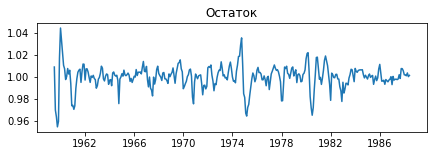


Проверка сезональности на стационарность

p-value:  -5.34031526959e+13
Critical values:  {'1%': -3.4496162602188187, '5%': -2.870028369720798, '10%': -2.5712922615505627}
Единичных корней нет, временной ряд стационарен


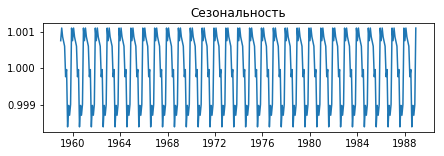


Проверка остатка на стационарность

p-value:  -7.46608373979
Critical values:  {'1%': -3.4496162602188187, '5%': -2.870028369720798, '10%': -2.5712922615505627}
Единичных корней нет, временной ряд стационарен


In [173]:
models(data, 'multiplicate', 'Мультипликативная модель')


### Вывод: 
- Разложили ряд на тренд, сезональность и остаток.
- На примере временного ряда `training` видим, что
    + *Для аддитивной модели*
        1. Тренд не обладает стационарностью
        2. Cезональность обладают стационарностью
        3. Остаток обладает стационарностью
    + *Для мультипликативной модели*
        1. Тренд не обладает стационарностью
        2. Cезональность обладают стационарностью
        3. Остаток обладает стационарностью

## Поиск коэффициента интегрируемости ряда

In [174]:
def findOrder(ts, isPrint=False):
    integrationOrder = 0
    while not dfTest(ts, isPrint):
        ts = ts.diff().dropna()
        integrationOrder += 1
    return integrationOrder

k = findOrder(ts, True)
print(k)


p-value:  -0.253391179928
Critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459002}
Единичный корень есть, временной ряд не стационарен
p-value:  -7.36731149521
Critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459002}
Единичных корней нет, временной ряд стационарен
1


## Подбираем нужные параметры с помощью функции автокорреляции и функции частичной автокорреляции

In [175]:
train = pd.read_csv('training.csv', parse_dates=['Date'],
                    index_col='Date')

ts = train['Value']

p = 1
q = 1


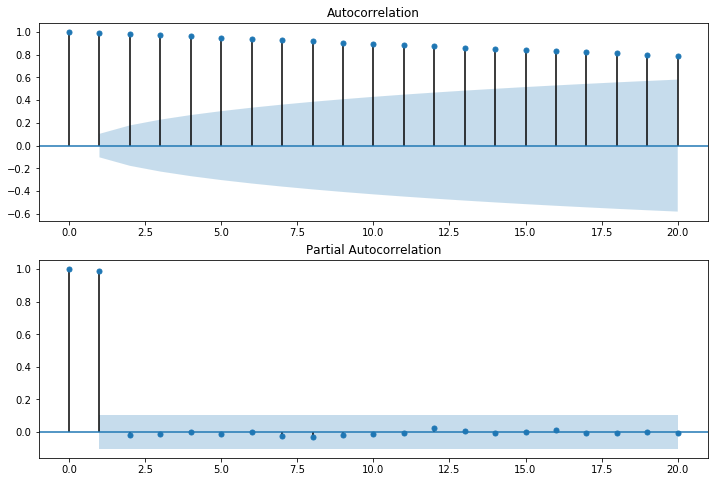

In [176]:
lag_acf = acf(ts, nlags=20)
lag_pacf = pacf(ts, nlags=20, method='ols')

ig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=20, ax=ax1)
ax2 = plt.subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags=20, ax=ax2)

q = int(lag_acf[0])
p = int(lag_pacf[0])

print('p =', p)
print('q =', q)


* После изучения карреолограммы ACF (autocorrelation function) приходим к выводу, что p=1, т.к. на ней только 1 лаг сильно отличнен от нуля
* По коррелограмме ACF можно увидеть, что q=1, т.к. после лага 1 значении функций резко падают.

## Применяем модель ARIMA

In [177]:
model = ARIMA(ts, order=(p, k, q))  # Применяем модель ARIMA
model = model.fit()  # Прогоняем ARIMA-модель через фильтр Калмана
plt.figure(figsize=(20, 10))
results_ARIMA = model.predict(typ='levels')

values = OrderedDict(
    ARIMA=results_ARIMA,
    Training=ts)
bokeh_plot = TimeSeries(values, width=900, height=500,
                        color=['ARIMA', 'Training'],
                        title='R2 Score: %.4f' % r2_score(ts['1959-02-01':],
                                                          results_ARIMA),
                        ylabel='Значения', xlabel='Время')

show(bokeh_plot)


## Тестовая выборка

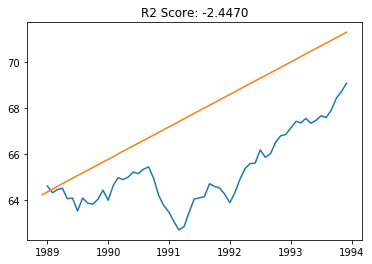

AIC= 248.73365724475457


In [178]:
data2 = pd.read_csv('testing.csv', parse_dates=['Date'],
                    index_col='Date')

ts = data2['Value']
predictions = model.predict(start='1988-12-01', end='1993-12-01',
                            typ='levels', dynamic=True)
plt.plot(ts)
plt.plot(predictions)
plt.title('R2 Score: %.4f' % r2_score(ts, predictions['1989-01-01':]))
plt.show()
print("AIC=", model.aic)


## Вывод: 
* Для ряда training коэффициент интегрированности равен 1.
* Логарифмируем ряд для увеличения точности, применяем к нему модель ARIMA, r2 score = 0.9523.

## SARIMAX

In [179]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

data = pd.read_csv('training.csv', parse_dates=['Date'],
                   index_col='Date')
ts = data
model = SARIMAX(ts, order=(p, k, q),
                seasonal_order=(p, k, q, 12))  # Применяем модель ARIMA
model_res = model.fit()  # Прогоняем ARIMA-модель через фильтр Калмана
results_SARIMAX = model_res.predict()

values2 = OrderedDict(
    SARIMAX=results_SARIMAX['1959-02-01':],
    Training=ts['Value'])
bokeh_plot = TimeSeries(values2, width=900, height=500,
                        color=['SARIMAX', 'Training'],
                        ylabel='Значения', xlabel='Время')

show(bokeh_plot)

# Success:
# p, k, q     => -2.3815 (-1.02)
# p+1, k, q+1 => -1.7780 (-0.6743)
# p+2, k, q+1 => (-0.5296)
# p+2, k, q+2 => (-0.3699)
# p+4, k, q+2 => (-0.4162)
# p+3, k, q+3 => -1.2308 (-0.4220)
# p+2, k, q+3 => (-0.6070)
# p+3, k, q+2 => (-0.4312)
# p+4, k, q+4 => (-0.2547)
# p+5, k, q+4 => -0.3815 (0.0673)
# p+6, k, q+4 => -0.1149 (0.1012)
# p+7, k, q+4 => -0.0071 (0.1362) +++++++
# p+8, k, q+4 => -0.0888 (0.1816)
# p+9, k, q+4 => (-0.1931)
# p+10, k, q+4 => -0.4800(-0.2175)

# Apple Eye Emerald Drum Madness Sail Likelihood Desk King Gas Sale Egg Gang Group Puddle East Toast Text Table Edge Evil Lake
# Eavesdropper Ring Goose Eggplant Tennis Sea Animal Lion Nostril Line Equation Night Trump Poker Rocket Task Key Year Rat Tusk
# Killer Risk Knight Teen Neglection Node Emphasis Steel Love Engine Emotion Network Kimono Orange Elbow Worm Mom Mask Karate
# Entrance Elf Face Editor Rage Ease Economics Sculpture Eruption North Hale Evolution Nudist Trap P

## Тестовая выборка

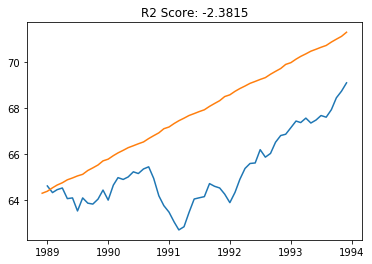

AIC= 290.431090293


In [180]:
data2 = pd.read_csv('testing.csv', parse_dates=['Date'], index_col='Date')

ts = data2['Value']
predictions = model_res.predict(start='1988-12-01', end='1993-12-01',
                                dynamic=True)
plt.plot(ts)
plt.plot(predictions)
plt.title('R2 Score: %.4f' % r2_score(ts, predictions['1989-01-01':]))
plt.show()
print("AIC=", model_res.aic)
